# 전력 수요량 예측 경진대회
<hr>

*참고 코드*
- <https://dacon.io/competitions/official/196878/codeshare/418?page=1&dtype=recent&ptype=pub>

<br><br>
## 라이브러리

In [151]:
# -*- coding: utf8-*-
# General Library
import numpy as np
import pandas as pd
import time
import datetime
import random
import os
import matplotlib.pyplot as plt

# Machine Learning Library
import lightgbm as lgb
import sklearn
from sklearn.model_selection import train_test_split

In [152]:
# seed 고정
seed = 777
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)

# 버전 정보
print('Seed: %i'%(seed))
print('Numpy: %s'%(np.__version__))
print('Pandas: %s'%(pd.__version__))
print('LightGBM: %s'%(lgb.__version__))
print('Scikit-Learn: %s'%(sklearn.__version__))

Seed: 777
Numpy: 1.19.2
Pandas: 1.1.3
LightGBM: 3.1.1
Scikit-Learn: 0.23.2


In [153]:
# Load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [154]:
weather=pd.read_csv('./data/인천_시간별__기상자료(16-18)_축소__7월1일.csv',encoding='cp949')
weather.head()

,지점,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),날씨,전운량(10분위)
0,112,2016.7.20 0:00,25.7,NaN,1.3,98.0,NaN,박무,8.0
1,112,2016.7.20 1:00,25.6,NaN,1.4,98.0,NaN,NaN,NaN
2,112,2016.7.20 2:00,25.4,NaN,0.3,98.0,NaN,NaN,NaN
3,112,2016.7.20 3:00,24.9,NaN,1.1,98.0,NaN,박무,8.0
4,112,2016.7.20 4:00,24.7,NaN,0.7,98.0,NaN,박무,8.0


In [155]:
# 결측치 확인
weather.isnull().sum()

지점               0
일시               0
기온(°C)          31
강수량(mm)      15653
풍속(m/s)          0
습도(%)            7
적설(cm)       16578
날씨            3767
전운량(10분위)     3775
dtype: int64

In [156]:
## 결측치 처리
# 결측 데이터가 많지 않은 데이터는 전 값으로 대체
weather['기온(°C)']=weather['기온(°C)'].fillna(method='ffill')
weather['습도(%)']=weather['습도(%)'].fillna(method='ffill')
weather['전운량(10분위)']=weather['전운량(10분위)'].fillna(method='ffill')

# 결측 데이터가 많은 컬럼은 0으로 대체
weather['강수량(mm)']=weather['강수량(mm)'].fillna(0)
weather['적설(cm)']=weather['적설(cm)'].fillna(0)
weather['날씨']=weather['날씨'].fillna('nan')

In [157]:
# 타입 변환
weather['일시']=pd.to_datetime(weather['일시'])

<br><br>
## 데이터 전처리

In [158]:
# datetime으로 변환
train['Time']=pd.to_datetime(train['Time'])
test['Time']=pd.to_datetime(test['Time'])

In [159]:
# nan to zero
train.fillna(0,inplace=True)
test.fillna(0,inplace=True)

In [160]:
# 날씨데이터를 일별로 만들기.
weather['day']=pd.to_datetime(weather['일시'].dt.strftime('%Y-%m-%d'))

In [161]:
def downsampling(df):
    result={}
    result['기온(°C)']=[df['기온(°C)'].mean()]
    result['강수량(mm)']=[df['강수량(mm)'].mean()]
    result['풍속(m/s)']=[df['풍속(m/s)'].mean()]
    result['습도(%)']=[df['습도(%)'].mean()]
    result['적설(cm)']=[df['적설(cm)'].mean()]
    #result['전운량(10분위)']=[df['전운량(10분위)'].value_counts().sort_values(ascending=False).index[0]]
    result['전운량(10분위)']=[df['전운량(10분위)'].mean()]
    return pd.DataFrame(result)
    
additional_columns=['day','기온(°C)','강수량(mm)','풍속(m/s)','습도(%)','적설(cm)','전운량(10분위)']

additional_data=weather.groupby(['day']).apply(downsampling).reset_index()[additional_columns].rename(columns={'day':'일시'})

In [162]:
additional_data

,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),전운량(10분위)
0,2016-07-20,27.887500,0.000000,2.054167,90.583333,0.0,6.708333
1,2016-07-21,27.945833,0.000000,2.700000,86.541667,0.0,8.000000
2,2016-07-22,28.437500,0.000000,2.925000,89.250000,0.0,4.708333
3,2016-07-23,27.641667,0.008333,3.137500,95.375000,0.0,8.583333
4,2016-07-24,27.120833,0.000000,2.479167,98.000000,0.0,9.000000
...,...,...,...,...,...,...,...
707,2018-06-27,20.262500,0.008333,2.583333,93.625000,0.0,9.291667
708,2018-06-28,22.391667,0.100000,2.250000,93.583333,0.0,9.875000
709,2018-06-29,22.437500,0.016667,1.879167,90.208333,0.0,7.791667
710,2018-06-30,23.708333,0.000000,1.395833,84.916667,0.0,9.375000


<br><br>
## EDA

In [213]:
train_id_num=(train.loc[:,'NX1':]>0).sum().index
train_id_num=train_id_num.str[2:].astype('int')

In [214]:
train_data_num=sorted((train.loc[:,'NX1':]>0).sum().values,reverse=True)

In [215]:
test_id_num=(test.loc[:,'NX1301':]>0).sum().index.str[2:].astype('int')
test_id_num=test_id_num-1300

In [216]:
test_data_num=(test.loc[:,'NX1301':]>0).sum().values

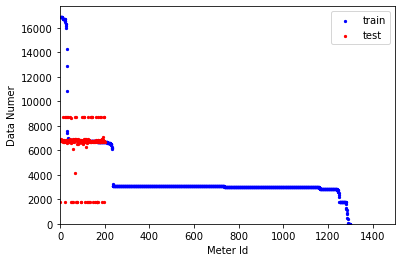

In [217]:
# scatter로 보기
plt.scatter(train_id_num, train_data_num, s=5, color='b', label='train')
plt.scatter(test_id_num, test_data_num, s=5, color='r', label='test')
plt.legend()
plt.xlim(0, 1500)
plt.ylim(bottom=0)
plt.xlabel('Meter Id')
plt.ylabel('Data Numer')
plt.show()

In [201]:
cond=((train.loc[:,'NX1':]>0).sum())>6000

In [204]:
cond.sum()

234